---
# Plankton Recognition Challenge
---


# Group 20 : Solution (Scratch)
## by Maxence Brugeres, Martin Guyard and Clément Bernard   


# Data preparation 

In [1]:
# Importations


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf
import zipfile
from io import BytesIO
from PIL import Image
import numpy as np



SEED = 77


In [2]:
# Load all the csv data 


meta = pd.read_csv('meta.csv')
taxo = pd.read_csv('taxo.csv')

In [3]:
meta.shape

(243610, 14)

In [4]:
meta.columns

Index(['objid', 'projid', 'id', 'status', 'latitude', 'longitude', 'objdate',
       'objtime', 'depth_min', 'depth_max', 'unique_name', 'lineage', 'level1',
       'level2'],
      dtype='object')

## 1. Data Preparation

In [5]:
indexes_nan_level2 = meta.level2[meta.level2.isnull()].index

meta.drop(indexes_nan_level2 , axis = 0, inplace = True)

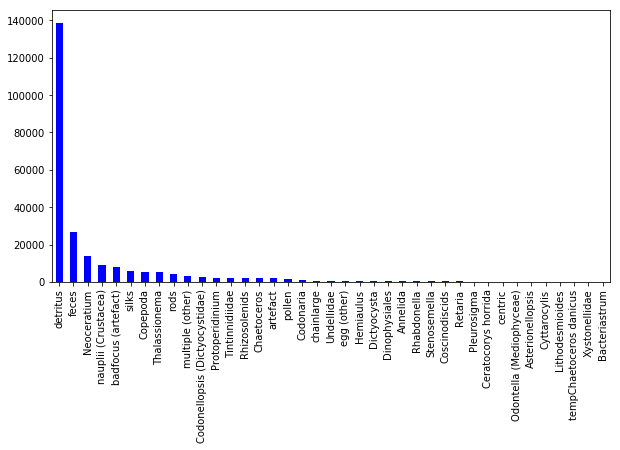

In [6]:
# Plot the repartition of the labels
meta.level2.value_counts().plot(kind='bar', color = 'b',figsize=(10,5))

In [7]:
# Convert the label into classes
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
meta.level2 = le.fit(meta.level2).transform(meta.level2)


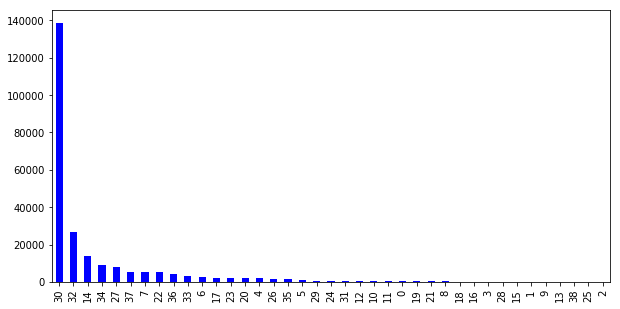

In [8]:
# Plot the repartition of the labels
meta.level2.value_counts().plot(kind='bar', color = 'b',figsize=(10,5))

### Data augmentation : 


In [9]:
# Global variable to balance the classes

SAMPLES_PER_CLASSES = 2000
SHAPE = (32,32)

In [10]:
import zipfile
from io import BytesIO
from PIL import Image
import numpy as np

def extract_zip_to_memory(input_zip):
    '''
    This function extracts the images stored inside the given zip file.
    It stores the result in a python dictionary.
    
    input_zip (string): path to the zip file
    
    returns (dict): {filename (string): image_file (bytes)}
    '''
    input_zip=zipfile.ZipFile(input_zip)
    return {name: BytesIO(input_zip.read(name)) for name in input_zip.namelist() if name.endswith('.jpg')}


img_files = extract_zip_to_memory("imgs.zip")

# Display an example image 
#Image.open(img_files['imgs/32738710.jpg'])

# Load the image as a numpy array:
#np_arr = np.array(Image.open(img_files['imgs/32738710.jpg']))

# Be aware that the dictionary will occupy roughly 2GB of computer memory!
# To free this memory again, run:
# del img_files

#### Drop over represented classes

In [11]:
# First we cut out the classes with number of samples > SAMPLES_PER_CLASSES
import random
random.seed(SEED) 
samples_count = meta.level2.value_counts()

for cls, count in zip(samples_count.index, samples_count):
    # In this case, we cut out the number of samples
    if count > SAMPLES_PER_CLASSES:
        idx_to_drop = random.sample(np.array(meta[meta.level2==cls].index).tolist(),count-SAMPLES_PER_CLASSES)
        meta.drop(index=idx_to_drop, inplace=True)

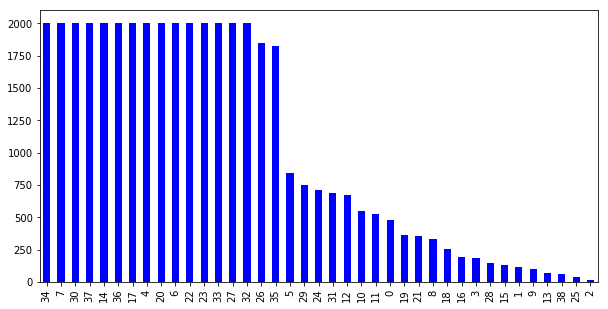

In [12]:
meta.level2.value_counts().plot(kind='bar', color = 'b',figsize=(10,5))

In [13]:
# Before over sampling some image, we split the dataset into train and test set:

from sklearn.model_selection import train_test_split

meta_train, meta_test = train_test_split(meta, test_size=0.2, random_state = SEED)
meta_valid, met_test = train_test_split(meta_test, test_size=0.5, random_state = SEED)

meta_valid.name = 'Valid_df'
meta_test.name = 'Test_df'
meta_train.name = 'Train_df'

#### Fill other classes

In [14]:
from time import time
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from IPython.display import clear_output

def get_train_test_valid(meta_df, sampleCoef):    
    
    def reshape_plankton_image(ima):
            width, height = ima.size
            if width == height:
                new_ima = ima
            elif width > height:
                new_ima = Image.new(ima.mode, (width, width), 255)
                new_ima.paste(ima, (0, (width - height) // 2))
            else:
                new_ima = Image.new(ima.mode, (height, height), 255)
                new_ima.paste(ima, ((height - width) // 2, 0))

            return new_ima.resize(SHAPE, Image.ANTIALIAS )

    def data_augmentation(objid_list, cls):
        """
        :param objid_list: list of a class objid
        :param cls: class name (eg: 31, 21...)

        :return :list of np.array of augmented data
        """
        augmentation = augmentation_dict[cls]
        samples = []
        res = np.zeros((augmentation, SHAPE[0], SHAPE[1]))

        for objid in objid_list:

            ima = Image.open(img_files['imgs/'+str(objid)+'.jpg'])
            reshaped_ima = reshape_plankton_image(ima)
            reshaped_ima_gray = np.expand_dims(np.array(reshaped_ima), 2)
            samples.append(reshaped_ima_gray)

        datagen = ImageDataGenerator(width_shift_range=[-3, 3], 
                                 height_shift_range=0.5,
                                 horizontal_flip=True, 
                                 rotation_range=20,
                                 vertical_flip=True,
                                 brightness_range=[0.2,1.0])

        it = datagen.flow(np.array(samples), batch_size=1, save_format='jpg')

        for i in range(augmentation):
            batch = it.next()
            image = np.squeeze(batch[0], axis=2)
            res[i] = image
        return res
    
    
    random.seed(SEED) 
    
    # First we cut out the classes with number of samples > SAMPLES_PER_CLASSES

    samples_count = meta_df.level2.value_counts()
    augmentation_dict = {} # key: class, value: number of augmentation

    for cls, count in zip(samples_count.index, samples_count):
        # In this case, we cut out the number of samples
        if count > int(SAMPLES_PER_CLASSES*sampleCoef):
            idx_to_drop = random.sample(np.array(meta_df[meta_df.level2==cls].index).tolist(),count-int(SAMPLES_PER_CLASSES*sampleCoef))
            meta_df.drop(index=idx_to_drop, inplace=True)

        augmentation_dict[cls] = max([int(SAMPLES_PER_CLASSES*sampleCoef-count), 0])
         
    
    X = np.zeros((39*int(SAMPLES_PER_CLASSES*sampleCoef), SHAPE[0], SHAPE[1]))
    y = np.zeros((39*int(SAMPLES_PER_CLASSES*sampleCoef), 39))

    origin_time = time()
    for cls in augmentation_dict:
        minut = int((time()-origin_time)/60)
        seco = int(int((time()-origin_time - minut*60)*100)/100)
        print(str(len(samples_count.index)) + " classes in " + meta_df.name)
        print("class " + str(cls) + " starts at " + str(minut) + "min " + str(seco)+"s")
        clear_output(True)
        augmentation = augmentation_dict[cls]
        image_id_of_cls = meta_df.objid[meta_df.level2 == cls].values.astype(int)
        new_images = data_augmentation(image_id_of_cls, cls)
        label = np.zeros(39)
        label[cls] = 1
        for index, image_id in enumerate(image_id_of_cls):
            ima = np.array(reshape_plankton_image(Image.open(img_files['imgs/'+str(image_id)+'.jpg'])))
            X[cls*int(SAMPLES_PER_CLASSES*sampleCoef) + augmentation + index] = ima
            y[cls*int(SAMPLES_PER_CLASSES*sampleCoef) + augmentation + index] = label
        for index, img in enumerate(new_images):
            X[cls*int(SAMPLES_PER_CLASSES*sampleCoef)+index] = img
            y[cls*int(SAMPLES_PER_CLASSES*sampleCoef)+index] = label
   
    return X,y
    

In [15]:
def convert_to_non_hot(y) : 
    new_y = np.zeros((y.shape[0],1))
    for index,val in enumerate(y) : 
        label = np.where(val ==1)[0][0]
        new_y[index,:] = label
    return new_y
    

In [16]:
X_train, y_train = get_train_test_valid(meta_train, 0.8)

39 classes in Train_df
class 38 starts at 1min 3s


In [17]:
X_valid, y_valid = get_train_test_valid(meta_valid, 0.1)

39 classes in Valid_df
class 38 starts at 0min 7s


In [18]:
X_test, y_test = get_train_test_valid(meta_test, 0.1)

39 classes in Test_df
class 38 starts at 0min 8s


# 2. Model Selection

In [19]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Reshape
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import tensorflow.keras.backend
from sklearn.metrics import f1_score
from tensorflow.keras import backend as K

def f1_m(y, y_pred):
    return tfmean(f1_score(tensorflow.keras.backend.eval(y), tensorflow.keras.backend.eval(y_pred), average="macro"))


def recall(y, y_pred):
    true_positives = K.sum(K.round(K.clip(y * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y, y_pred):
    true_positives = K.sum(K.round(K.clip(y * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y, y_pred):
    precision_v = precision(y, y_pred)
    recall_v = recall(y, y_pred)
    return 2*((precision_v*recall_v)/(precision_v+recall_v+K.epsilon()))


def plot_loss_metric(history) : 
    loss = history['loss']
    f1 = history['f1']
    
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color=color)
    ax1.plot(loss, color=color,marker='+')
    ax1.tick_params(axis='y', labelcolor=color)
    plt.grid(True)
    ax2 = ax1.twinx() 

    color = 'tab:blue'
    ax2.set_ylabel('F1 score', color=color)  
    ax2.plot(f1, color=color,marker='+')
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout() 
    plt.grid(True)
    plt.show()
    

## Simple NN

In [20]:
def simple_neural_network(input_shape) : 
    
    X_input = Input(input_shape)
    X = Flatten()(X_input)
    X = Dense(100, activation='relu', name ='fc0')(X)
    X = Dense(50, activation='relu', name ='fc1')(X)
    X = Dense(39, activation='softmax', name ='fc2')(X)
    
    model = Model(inputs = X_input , outputs=X , name = 'SimplePlankton')
    
    return model

In [21]:
simpleNN = simple_neural_network(X_train.shape[1:])

In [22]:
simpleNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics = [f1])

In [23]:
simpleNN.fit(x=X_train, y = y_train, epochs = 50 , batch_size = 500)

Train on 62400 samples
Epoch 1/50
62400/62400 [==============================] - 1s 18us/sample - loss: 30.6047 - f1: 0.0115
Epoch 2/50
62400/62400 [==============================] - 1s 11us/sample - loss: 3.6538 - f1: 0.0085
Epoch 3/50
62400/62400 [==============================] - 1s 12us/sample - loss: 3.6494 - f1: 0.0098
Epoch 4/50
62400/62400 [==============================] - 1s 13us/sample - loss: 3.6430 - f1: 0.0114
Epoch 5/50
62400/62400 [==============================] - 1s 10us/sample - loss: 3.6377 - f1: 0.0129
Epoch 6/50
62400/62400 [==============================] - 1s 10us/sample - loss: 3.6321 - f1: 0.0141
Epoch 7/50
62400/62400 [==============================] - 1s 11us/sample - loss: 3.6208 - f1: 0.0142
Epoch 8/50
62400/62400 [==============================] - 1s 11us/sample - loss: 3.5374 - f1: 0.0064
Epoch 9/50
62400/62400 [==============================] - 1s 12us/sample - loss: 3.4187 - f1: 0.0013
Epoch 10/50
62400/62400 [==============================] - 1s 11us/

In [24]:
simpleNN.evaluate(X_valid, y_valid)

7800/7800 [==============================] - 1s 65us/sample - loss: 2.9761 - f1: 0.0097


[2.9760913181304933, 0.009704256]

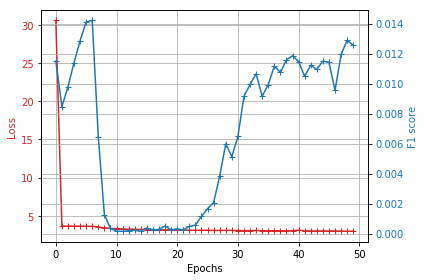

In [25]:
plot_loss_metric(simpleNN.history.history)

## Custom NN

In [32]:
def custom_model(input_shape) : 
    
    
    X_input = Input(input_shape)
    X = Reshape((input_shape[0],input_shape[1],1))(X_input)
    X = Conv2D(5, (5,5), strides = (1,1), name='conv0', activation='relu', padding='SAME')(X)
    X = MaxPooling2D(pool_size=(2,2), strides=(2,2), name = 'maxpool0', padding="VALID")(X)
    X = Conv2D(10, (4,4), strides = (1,1), name='conv1', activation='relu', padding='SAME')(X)  
    X = MaxPooling2D((2,2), strides=(2,2), name = 'maxpool1',  padding="VALID")(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Flatten()(X)

    X = Dense(39, activation='softmax', name ='fc')(X)
    
    model = Model(inputs = X_input , outputs=X , name = 'CustomPlankton')
    
    return model

In [33]:
customNN = custom_model(X_train.shape[1:])

In [34]:
customNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics = [f1])

In [49]:
customNN.fit(x=X_train, y = y_train, epochs = 10 , batch_size = 250)

Epoch 1/10
249600/249600 [==============================] - 80s 321us/step - loss: 1.7269 - f1: 0.3873
Epoch 2/10
249600/249600 [==============================] - 80s 320us/step - loss: 1.7242 - f1: 0.3880
Epoch 3/10
249600/249600 [==============================] - 80s 321us/step - loss: 1.7176 - f1: 0.3917
Epoch 4/10
249600/249600 [==============================] - 80s 322us/step - loss: 1.7124 - f1: 0.3934
Epoch 5/10
249600/249600 [==============================] - 80s 320us/step - loss: 1.7097 - f1: 0.3941
Epoch 6/10
249600/249600 [==============================] - 80s 320us/step - loss: 1.7083 - f1: 0.3949
Epoch 7/10
249600/249600 [==============================] - 80s 322us/step - loss: 1.7039 - f1: 0.3954
Epoch 8/10
249600/249600 [==============================] - 80s 322us/step - loss: 1.6995 - f1: 0.3982
Epoch 9/10
249600/249600 [==============================] - 80s 321us/step - loss: 1.6955 - f1: 0.3991
Epoch 10/10
249600/249600 [==============================] - 80s 319us/st

In [59]:

result_custom = customNN.evaluate(X_valid, y_valid)
print('Loss on the validation set : {}\nF1 score for validation set : {}'.format(*result_custom))

31200/31200 [==============================] - 9s 298us/step
Loss on the validation set : 1.7741037222895866
F1 score for validation set : 0.32323287647886156


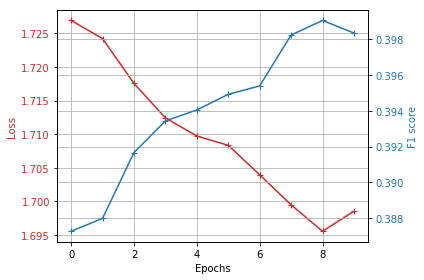

In [50]:
plot_loss_metric(customNN.history.history)

<br>
<br>

**F1 score is better in trainning than validation, maybe try dropout to reduce the gap ?**
<br>
<br>

## Custom NN with regularisation

In [ ]:
def custom_model_reg(input_shape) : 
    
    
    X_input = Input(input_shape)
    X = Reshape((input_shape[0],input_shape[1],1))(X_input)
    X = Dropout(0.3)(X)
    X = Conv2D(5, (5,5), strides = (1,1), name='conv0', activation='relu', padding='SAME')(X)
    X = MaxPooling2D(pool_size=(2,2), strides=(2,2), name = 'maxpool0', padding="VALID")(X)
    X = Conv2D(10, (4,4), strides = (1,1), name='conv1', activation='relu', padding='SAME')(X)  
    X = Dropout(0.3)(X)
    X = MaxPooling2D((2,2), strides=(2,2), name = 'maxpool1',  padding="VALID")(X)
    X = Dropout(0.5)(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Flatten()(X)

    X = Dense(39, activation='softmax', name ='fc')(X)
    
    model = Model(inputs = X_input , outputs=X , name = 'CustomPlankton')
    
    return model

In [ ]:
customNN_reg = custom_model_reg(X_train.shape[1:])

In [ ]:
customNN_reg.compile(optimizer='adam', loss='categorical_crossentropy', metrics = [f1])

In [ ]:
customNN_reg.fit(x=X_train, y = y_train, epochs = 10 , batch_size = 250)

In [58]:

result_custom = customNN_reg.evaluate(X_test, y_test)
print('Loss on the validation set : {}\nF1 score for validation set : {}'.format(*result_custom))

31200/31200 [==============================] - 9s 301us/step
Loss on the validation set : 1.7303559899788636
F1 score for validation set : 0.3602788658363697


In [ ]:
plot_loss_metric(customNN_reg.history.history)

## Transfer Learning 

We decided to remove the number of data for computation, as the model we'll use as a lot of layers

In [9]:
# Global variable to balance the classes

SAMPLES_PER_CLASSES = 2000
SHAPE = (32,32)

In [15]:
X_train, y_train = get_train_test_valid(meta_train, 0.8)

39 classes in Train_df
class 38 starts at 1min 64s


In [16]:
X_valid, y_valid = get_train_test_valid(meta_valid, 0.1)

39 classes in Valid_df
class 38 starts at 0min 7s


In [17]:
X_test, y_test = get_train_test_valid(meta_test, 0.1)

39 classes in Test_df
class 38 starts at 0min 8s


VGG16 is a convolutional neural network model that achieved 92.7% on top-5 test accuracy in ImageNet, which is a dataset of over 14 million images belonging to 1000 classes. 

We decided to use this architecture for our problem. 

In [21]:
from keras.applications.vgg16 import VGG16

Using TensorFlow backend.


In [22]:
X_train_tf = np.stack([X_train.reshape(-1,32,32)]*3, axis=-1)
X_val_tf = np.stack([X_valid.reshape(-1,32,32)]*3, axis=-1)
X_test_tf = np.stack([X_test.reshape(-1,32,32)]*3, axis=-1)


In [23]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten


def transfer_model(input_shape) : 
    
    pretrained_model = tf.keras.applications.VGG(input_shape=input_shape, include_top=False)
    pretrained_model.trainable = False

    model = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(39, activation='softmax')
        ])
    
    
    return model
    
    
    

In [23]:
t_model = transfer_model(X_train_tf.shape[1:])

In [24]:
t_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 39)                20007     
Total params: 14,734,695
Trainable params: 20,007
Non-trainable params: 14,714,688
_________________________________________________________________


In [25]:
t_model.compile(optimizer='adam',  loss='categorical_crossentropy', metrics = [f1])

In [26]:
t_model.fit(x=X_train_tf, y = y_train, epochs = 20 , batch_size = 1500)

Train on 62400 samples
Epoch 1/20
62400/62400 [==============================] - 55s 879us/sample - loss: 22.3527 - f1: 0.1229
Epoch 2/20
62400/62400 [==============================] - 53s 847us/sample - loss: 7.3316 - f1: 0.3304
Epoch 3/20
62400/62400 [==============================] - 53s 847us/sample - loss: 4.7843 - f1: 0.4250
Epoch 4/20
62400/62400 [==============================] - 82s 1ms/sample - loss: 3.7125 - f1: 0.4757
Epoch 5/20
62400/62400 [==============================] - 142s 2ms/sample - loss: 3.0834 - f1: 0.5101
Epoch 6/20
62400/62400 [==============================] - 143s 2ms/sample - loss: 2.6580 - f1: 0.5338
Epoch 7/20
62400/62400 [==============================] - 140s 2ms/sample - loss: 2.3520 - f1: 0.5534
Epoch 8/20
62400/62400 [==============================] - 140s 2ms/sample - loss: 2.1140 - f1: 0.5713
Epoch 9/20
62400/62400 [==============================] - 142s 2ms/sample - loss: 1.9325 - f1: 0.5834
Epoch 10/20
62400/62400 [==============================]

In [27]:
result_transfer = t_model.evaluate(X_val_tf, y_valid, batch_size=250)


7800/7800 [==============================] - 17s 2ms/sample - loss: 1.7127 - f1: 0.5448


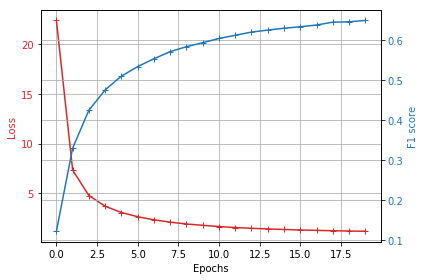

In [28]:
plot_loss_metric(t_model.history.history)

In [29]:
print('Loss on the validation set : {}\nF1 score for validation set : {}'.format(*result_transfer))

Loss on the validation set : 1.712702908577063
F1 score for validation set : 0.5447560548782349


In [30]:
result_transfer_test = t_model.evaluate(X_test_tf, y_test, batch_size=250)


7800/7800 [==============================] - 17s 2ms/sample - loss: 1.6875 - f1: 0.5667


In [31]:
print('Prediction on the test :\nLoss : {}\nF1 score :{}'.format(*result_transfer_test))

Prediction on the test :
Loss : 1.6875102722491973
F1 score :0.5667461156845093


In [9]:
f1_scores = {'Simple Neural Network' : [2.97,0.009] , \
             'Custom CNN' : [1.83,0.31], \
             'Custom CNN Dropout': [1.75,0.35],\
            'Transfer Learning fine-tuned' : [1.71,0.54]}

In [10]:
import pandas as pd
df = pd.DataFrame(f1_scores, columns = ['Simple Neural Network','Custom CNN','Custom CNN Dropout',\
                                       'Transfer Learning fine-tuned'],\
                 index = ['Loss','F1 score'])


In [11]:
df

,Simple Neural Network,Custom CNN,Custom CNN Dropout,Transfer Learning fine-tuned
Loss,2.970,1.83,1.75,1.71
F1 score,0.009,0.31,0.35,0.54


## Features based classification

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf

SEED = 77

meta = pd.read_csv('meta.csv')
taxo = pd.read_csv('taxo.csv')

features_nat = pd.read_csv('features_native.csv.gz')
features_sk = pd.read_csv('features_skimage.csv.gz')

In [111]:
df = meta.merge(features_nat, left_on='objid', right_on='objid')
df = df.merge(features_sk , left_on='objid', right_on = 'objid')

In [112]:
# Print the features that have high ratio of NaN values
features_nan_drop = (df.isnull().sum()/df.shape[0]*100).sort_values(ascending = False)
print(features_nan_drop.head(20))

weighted_moments_normalized0    100.000000
moments_normalized0             100.000000
weighted_moments_normalized4    100.000000
moments_normalized1             100.000000
moments_normalized4             100.000000
weighted_moments_normalized1    100.000000
cdexc                            14.132425
feretareaexc                     14.132425
perimareaexc                     14.132425
nb3_area                          2.813513
symetrieh_area                    2.813513
symetriev_area                    2.813513
nb1_area                          2.813513
nb2_area                          2.813513
skeleton_area                     2.813513
convarea_area                     2.813513
level1                            1.368581
level2                            0.411724
projid                            0.000000
meanpos                           0.000000
dtype: float64


In [113]:
# Drop the nan values features that have higher Nan values than 10 %

df.drop(features_nan_drop[:9].keys(), axis=1,inplace = True)




In [114]:
# Drop the NaN values for the label 

indexes_nan_level2 = df.level2[df.level2.isnull()].index

df.drop(indexes_nan_level2 , axis = 0 , inplace = True)



In [115]:
# Drop level1 as this is not our target 

df.drop(['level1'],axis=1, inplace=True)

In [116]:
nan_features = df.columns[(df.isnull().sum()!=0)]

In [117]:
# Fill NaN with 0 
for feature in nan_features : 
    
    df[feature].fillna(0, inplace=True)


### Conversion categorical values

In [118]:
categorical_features = df.columns[df.dtypes == object]

In [119]:
df[categorical_features[0]].replace({'V':1}, inplace=True)      

In [120]:
# Convert the date into the number of days from the first date
df[categorical_features[1]] = pd.to_datetime(df[categorical_features[1]])    
df[categorical_features[1]] = (df[categorical_features[1]] - df[categorical_features[1]].min())  / np.timedelta64(1,'D')

In [121]:
# Drop the categorical features that can be converted easily 
df.drop([categorical_features[2],categorical_features[3],categorical_features[4]],axis=1, inplace=True)

In [122]:
row_drop = np.where(df.level2 == 'detritus')[0].shape[0] - 26936

In [128]:
indexes = df[df.level2 == 'detritus'].index[:row_drop]

In [130]:
df.drop(indexes,inplace=True)

In [132]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
df.level2 = le.fit(df.level2).transform(df.level2)




In [134]:

from sklearn.model_selection import train_test_split
y = df.level2.values
X = df.drop(['level2'],axis=1).values


X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=SEED)



In [135]:
from sklearn.metrics import f1_score

def f1score(y,y_predict) :
    # f1 score with the average done 
    return f1_score(y,y_predict , average = 'macro')




In [136]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import fbeta_score, make_scorer

def plot_scores(clf,name) :
    
    
    clf_score = cross_validate(clf, X_train, y_train, scoring={'f1_score': make_scorer(f1score)}, cv=5)
    
    y_predict_clf = clf.fit(X_train, y_train).predict(X_train)
    
    
    
    data = {'Training set' : [f1score(y_predict_clf,y_train)],
           'Validation set': [clf_score['test_f1_score'].mean()]}
    
    df = pd.DataFrame(data, columns=['Training set','Validation set'], index=['F1 score'])
    print('Model used : {}'.format(name))
    return df
    

In [137]:
from sklearn.ensemble import RandomForestClassifier

rfr = RandomForestClassifier(max_depth=20, random_state=SEED)


In [138]:
plot_scores(rfr, 'Random Forest')

Model used : Random Forest


,Training set,Validation set
F1 score,0.999747,0.762654


In [140]:
y_pred = rfr.fit(X_train,y_train).predict(X_test)

In [141]:
print('Finale score on test : {}'.format(f1score(y_test, y_pred)))

Finale score on test : 0.7664246351669989
